<a href="https://colab.research.google.com/github/SebinLee/Speech_Emotion_Recognition/blob/main/Speech_Emotion_Recognition_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the RAVDESS Emotional Speech Audio Dataset
For this model we used RAVDESS Emotional speech audio from Kaggle: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio

Files
This portion of the RAVDESS contains 1440 files:

60 trials per actor x 24 actors = 1440
The data was made by 12 female, 12 male professional actors vocalizing two lexically-matched statements in a neutral North American accent.
Speech emotions includes calm, happy, sad, angry, fearful, surprise, and disgust expressions.
Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [ ]:
# If you use Colab, run this cell to install additional dependencies
# Install addtional dependencies
!pip3 install torch torchvision torchaudio
!pip3 install fastai --upgrade
!pip3 install fastcore
!pip3 install sounddevice
!sudo apt-get install libportaudio2

In [ ]:
# If you use Colab, run this cell
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add Google Drive path to import local class
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/SpeechEmotionRecognition')
file_root = "/content/drive/My Drive/Colab Notebooks/SpeechEmotionRecognition"

In [1]:
# If you use local machine, run this cell
file_root = "/Users/sebinlee/Desktop/Github/SERPractice"

In [2]:
import os                                             # The OS module in Python provides a way of using operating system dependent functionality.
import numpy as np                                    # Used for working with arrays
import pandas as pd
import matplotlib.pyplot as plt                       # Allows you to plot things
import glob                                           # Used to return all file paths that match a specific pattern
import fetch_label                                    # Local class

# Please note: the fetch_label import references a local class that you should define in your local computer. 
# @maheshwari-nikhil on GitHub made this class that you can use: https://github.com/maheshwari-nikhil/emotion-recognition/blob/master/fetch_label.py
label = fetch_label.FetchLabel()                      # Retrieve files/pathnames matching a specified pattern

# Import fast AI
from fastai import *                                 
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.tabular.all import *
from fastai.text.all import *
from fastai.vision.widgets import *\

# Live Audio
import librosa                                        # Python package for music and audio analysis
import librosa.display                                # Allows you to display audio files 
from tkinter import TclError
from scipy.fftpack import fft                         # Imports all fft algorithms 
from scipy.io.wavfile import write


In [3]:
# Global var for directories
AUDIO_FOLDER = os.path.join(file_root, "audio-dataset/*")
OUTPUT_FOLDER_TRAIN = os.path.join(file_root, "Development/output_folder_train/")
OUTPUT_FOLDER_TEST = os.path.join(file_root, "output_folder_test/")
TESTING_DATA_FOLDER = os.path.join(file_root, "testing_data/")
TESTING_RESULT_FOLDER = os.path.join(file_root,"testing_result/")


# Plotting audio file

In [ ]:
def convert_audio_to_spectrogram(audio_file_path, specto_save_path) :
    # Convert to melspectrogram
    y, sr = librosa.load(audio_file_path)                 # Load the file with librosa
    yt,_=librosa.effects.trim(y)                    # Trim leading and trailing silence from an audio signal.          
    y=yt

    # Creare spectrogram from audio file
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=100)
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
    librosa.display.specshow(mel_spect, y_axis='mel', fmax=20000, x_axis='time')
    
    # Save to the aforementioned path
    plt.savefig(specto_save_path)
    print("Done!")

# Extract features from audio using librosa

In [ ]:
for actor in glob.glob(AUDIO_FOLDER):               # Loop through each actor in the data set 
  for name in glob.glob(actor +'/*'):               # Go through each audio file in each of the actors datasets
    print(name[-18:-16])                            # Sanity check: Check for name of file
    emotion = label.get_emotion(name[-24:])         # From audio file naming convention get the emotion of the data
    print(emotion)                                  # Sanity check: Check emotion name

In [9]:
# Dictionary with the numerical value that corresponds to each emotion
dicts={'01' : 'neutral', '02' : 'calm', '03' : 'happy', '04' : 'sad', '05' : 'angry', '06' : 'fearful', '07' : 'disgust', '08' : 'surprised'}

In [ ]:
counts = {}
for actor in glob.glob(AUDIO_FOLDER):               # Loop through each actor in the data set 
  for audioFile in glob.glob(actor +'/*'):          # Loop over each audio file in that directory
    emotion=dicts[audioFile[-18:-16]]               # Returns numbers from the audio file name, using the dictionary mapping each numerical value to emotions 

    # Logic to split up test and train data
    save_path = ""
    count = counts.get(emotion, 1)
    
    if count % 8 == 0 :
      save_path = OUTPUT_FOLDER_TEST + emotion
    else :
      save_path = OUTPUT_FOLDER_TRAIN + emotion

    if os.path.exists(save_path) == False :
      os.mkdir(save_path)

    counts[emotion] = count + 1
    p = os.path.join(save_path, "{}{}.jpg".format(emotion, str(count).zfill(6)))    
    if os.path.isfile(p) :
      continue

    # Convert Audio to Spectrogram image
    convert_audio_to_spectrogram(audioFile, p)
  print("{} Done!".format(actor.split("/")[-1]))                                                         


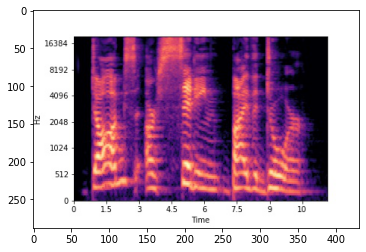

In [13]:
# Print one image from sorted array file
img = plt.imread(os.path.join(OUTPUT_FOLDER_TRAIN,'angry/angry000001.jpg'))
plt.imshow(img)

In [ ]:
train_path = Path(OUTPUT_FOLDER_TRAIN)
valid_path = Path(OUTPUT_FOLDER_TEST)
main_path = Path(AUDIO_FOLDER[:-2])

# List all sentiment groups 
train_path.ls()

In [ ]:
# Create from imagenet style dataset in path with train and valid subfolders (or provide valid_pct)
dls = ImageDataLoaders.from_folder(train_path, valid_pct=0.2, seed=42, num_workers=0)
dls.valid_ds.items[:10]

In [16]:
# Showcase the sentiment categories 
dls.vocab

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

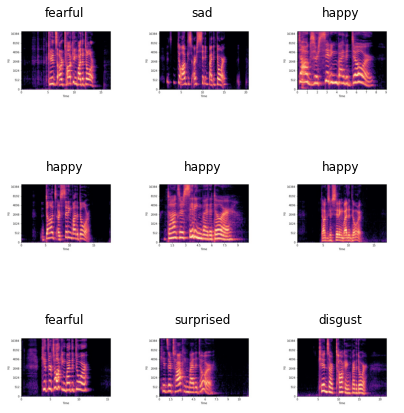

In [37]:
# See what a sample of a batch looks like
dls.show_batch(figsize=(7,8))

/Users/sebinlee/miniforge3/envs/ml38/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-jhk0fkj8/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Minimum/10: SuggestedLRs(valley=0.0010000000474974513)


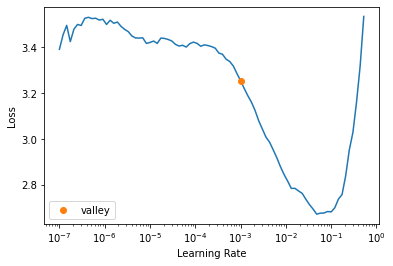

In [17]:
# This method creates a Learner object from the data object and model inferred from it with the backbone given in base_arch.
# ResNet-34 Pre-trained Model for PyTorch
learn = cnn_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# Find optimum learning rate (the steepest point)
lr = learn.lr_find()
print(f"Minimum/10: {lr}")

Sanity Check

In [18]:
print('learn.data.vocab', learn.dls.vocab)

learn.data.vocab ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [20]:
# Train (fit) using the optimum learning rate
learn.fit(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,2.594759,1.986400,0.355072,06:45
1,1.923945,1.784504,0.391304,06:49
2,1.475274,1.502000,0.521739,06:42
3,1.158343,1.657799,0.489130,06:41
4,0.936113,1.534463,0.510870,06:36
5,0.745026,1.488949,0.532609,06:43
6,0.606513,1.437811,0.554348,06:47
7,0.490947,1.553023,0.518116,06:45
8,0.399276,1.533019,0.550725,06:36
9,0.329439,1.539162,0.561594,06:34


In [4]:
# Plotting The losses for training and validation
learn.show_results()

NameError: name 'learn' is not defined

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

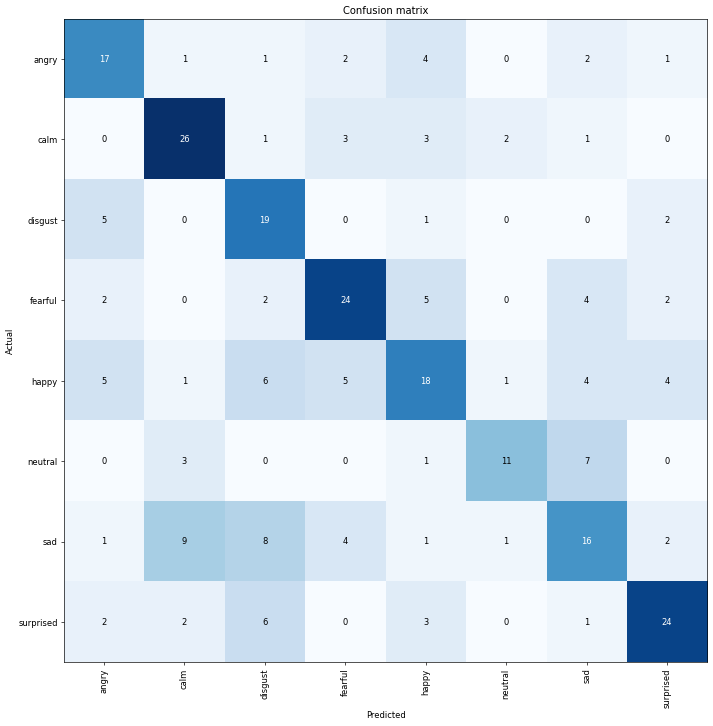

In [23]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [24]:
learn.freeze()

In [25]:
learn.export('speech_02.pkl')

# Live Audio

In [4]:
model = load_learner(os.path.join(OUTPUT_FOLDER_TRAIN, 'speech_02.pkl'))
print('model loaded')

model loaded


In [ ]:
fs=44100
second=3
export_data = np.array([])

for folder in glob.glob(OUTPUT_FOLDER_TEST + "/*"):
  for file_name in glob.glob(folder + "/*") :
    img = plt.imread(file_name)

    # Print one image from sorted array file
    curr_emotion, _, _ = model.predict(img)
    export_data = np.append(export_data, [file_name, curr_emotion])
    print(export_data)

print(export_data.reshape(-1,2))
pd.DataFrame(export_data.reshape(-1,2), columns=["filename","predict"]).to_csv("result.csv")
print("Done")